# <center> Costa Rican Household Poverty Level Prediction </center>

---

# Content
- [Problem Statement](#Problem-Statement)
- [Main Objective](#Main-Objective)
- [Data Exploratory](#Data-Exploratory)
- [Data Munging](#Data-Munging)

# Problem Statement

---

Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

# Main Objective

---

We strive to improve the accuracy of the predicting households' level of need by proposing a using a new model - Linear Regression. With the given variables in the dataset, we set out to predict poverty on a `household level`.

# Dataset Information

---

Core Data fields

    Id - a unique identifier for each row.
    Target - the target is an ordinal variable indicating groups of income levels. 
        1 = extreme poverty 
        2 = moderate poverty 
        3 = vulnerable households 
        4 = non vulnerable households
    idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. 

All rows in a given household will have a matching value for this identifier.
parentesco1 - indicates if this person is the head of the household.
This data contains 142 total columns.

All other data fields [can be found here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data).


# Data Munging

---

Importing libraries and set graph style

In [10]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

#### Reading training dataset

In [11]:
train = pd.read_csv("train.csv")

We first find out the data types for each column

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Lets take a look at the 5  columns that are `object` datatypes

In [18]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We will not be including the individual id and household id in our machine learning model, so lets investigate the other 3 columns that we may put into the machine learning model.

 According to the documentation for these columns:

* `dependency`: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* `edjefe`: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* `edjefa`: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

For now, lets dive deeper into the 3 columns to see what values they contain.
For `dependency` :

In [27]:
train.select_dtypes('object')['dependency'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
1.3333334      84
.40000001      84
2.5            77
5              24
1.25           18
3.5            18
.80000001      18
2.25           13
.71428573      12
.22222222      11
1.75           11
1.2            11
.83333331      11
.2857143        9
.60000002       8
1.6666666       8
6               7
.16666667       7
Name: dependency, dtype: int64

In [28]:
train.select_dtypes('object')['edjefe'].value_counts()

no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: edjefe, dtype: int64

In [29]:
train.select_dtypes('object')['edjefa'].value_counts()

no     6230
6       947
11      399
9       237
8       217
15      188
7       179
5       176
3       152
4       136
14      120
16      113
10       96
2        84
17       76
12       72
yes      69
13       52
21        5
19        4
18        3
20        2
Name: edjefa, dtype: int64

As we scan through, realise that all values are float or integer except for string of `yes` and `no`

#### Since they mentioned that `yes` = 1, `no` = 0 - we will replace them with 1 and 0 respectively

In [31]:
mapping = {"yes": 1, "no": 0}

train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['edjefa'] = train['edjefa'].replace(mapping).astype(np.int64)
train['edjefe'] = train['edjefe'].replace(mapping).astype(np.int64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


## Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where `parentesco1 == 1` because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

In [38]:
train

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.000000,100.000000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.000000,144.000000,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.000000,121.000000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.000000,121.000000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.000000,121.000000,1369,4
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,1.0,0,...,121,1444,16,121,4,1.777778,1.000000,121.000000,1444,4
6,ID_e9e0c1100,180000.0,0,5,0,1,1,1,1.0,0,...,4,64,16,121,4,1.777778,1.000000,121.000000,64,4
7,ID_3e04e571e,130000.0,1,2,0,1,1,0,NaN,0,...,0,49,16,81,4,16.000000,1.000000,100.000000,49,4
8,ID_1284f8aad,130000.0,1,2,0,1,1,0,NaN,0,...,81,900,16,81,4,16.000000,1.000000,100.000000,900,4
9,ID_51f52fdd2,130000.0,1,2,0,1,1,0,NaN,0,...,121,784,16,81,4,16.000000,1.000000,100.000000,784,4


In [40]:
heads['idhogar']

0       21eb7fcc1
1       0e5d7a658
2       2c7317ea8
5       2b58d945f
8       d6dae86b7
12      bb2094100
13      c51f9c774
18      6893e65ca
20      d29058053
21      ec0e8edce
23      3e16fab89
26      1e84a2ac8
27      759df0194
30      f2fcf00fd
33      cb6bb28dd
39      cbf24a06c
40      922a1f87a
43      a57a1f2f4
45      9b084b23d
49      6ddd55b3e
53      652a7ffa0
56      b9d64d752
58      09a26c158
59      e2f9717d3
61      65d20b573
64      d9281c805
68      5f7699c70
72      a0a822586
74      b2ceb3e5c
77      69bfa2895
          ...    
9477    c7ce4e30c
9480    7a78ffdc2
9481    339954bdc
9485    12cd558c5
9487    e9a1d7221
9490    5ba48ed17
9492    c91fc39d8
9495    47d5910c8
9499    029f3d736
9502    76ca7bf61
9505    95321ad13
9506    6548edd92
9507    053f09ebb
9508    820aeb574
9510    013962b12
9512    394ffb973
9515    9426b5ed9
9517    bfa964736
9519    ba41e31d5
9523    fa044cfe0
9526    fef7fd222
9528    bb631bc5d
9530    2fa33aed8
9531    08908240a
9534    b5

1     222
2     442
3     355
4    1954
Name: Target, dtype: int64

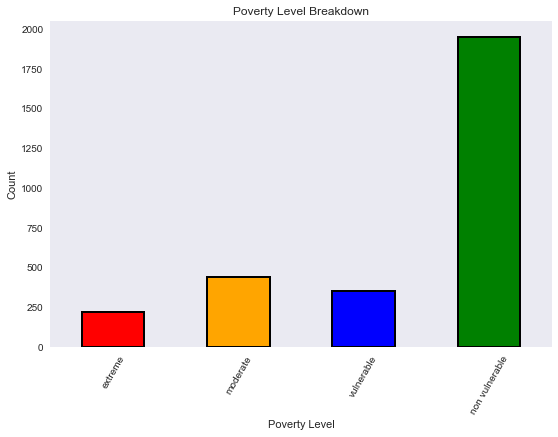

In [43]:
# Heads of household
heads = train.loc[train['parentesco1'] == 1].copy()

# Labels for training
train_labels = heads[['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

In [ ]:
len(train)

Since they mentioned that we should only choose the `household head`, we remove rows(individuals) that are not the `household head`

Household_leaders:
`parentesco1, =1 if household head`